In [1]:
!pip install ta tscv yfinance ipykernel -U --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import requests
import seaborn as sns
import ftplib

In [7]:
start_date = "2024-03-01"
end_date = "2024-08-19"
ticker = "AKSA"
stock_name = f"{ticker}.IS"
df = yf.download(tickers=stock_name, start=start_date, end=end_date, rounding=True)
df.head()

/var/folders/fc/2lr9_s2x3xz1k16vv8t9vttr0000gn/T/ipykernel_33288/1813978845.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=stock_name, start=start_date, end=end_date, rounding=True)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AKSA.IS,AKSA.IS,AKSA.IS,AKSA.IS,AKSA.IS
Date,,,,,
2024-03-01,8.07,8.27,7.99,8.11,30873264
2024-03-04,7.84,8.22,7.84,8.17,32333052
2024-03-05,8.18,8.40,7.81,7.90,42267300
2024-03-06,7.75,8.24,7.75,8.18,21152712
2024-03-07,8.05,8.05,7.79,7.79,18443448


ValueError: Data must be 1-dimensional, got ndarray of shape (112, 1) instead

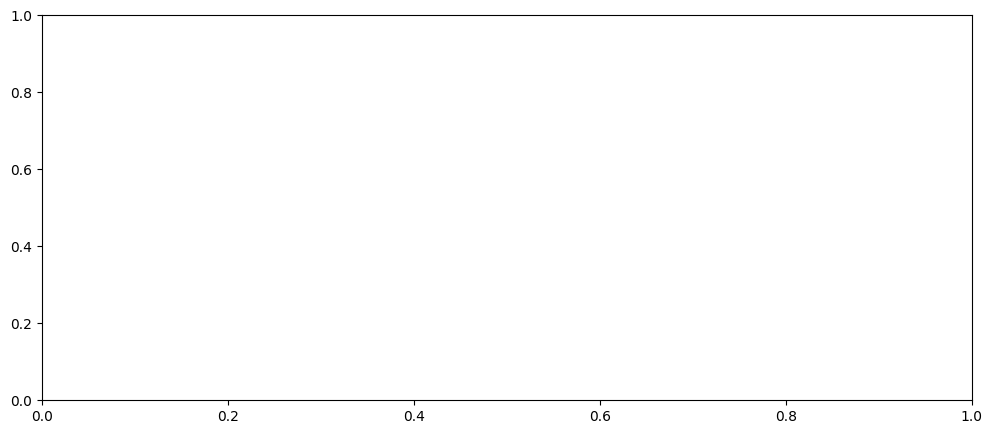

In [4]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=df, x=df.index, y="Close")
plt.title(f"{ticker} Price")
plt.show();

In [ ]:
df.rename(columns={"Adj Close":"Price"}, inplace=True)  # We will work on 'Price' column.
df["Return"] = df["Price"].diff() # Calculate daily changes in price
df["Return_pct"] = df["Price"].pct_change() # Calculate daily percentage changes.

In [ ]:
df["Target_cls"] = np.where(df["Return"]>0,1,0) # Mark positive days as 1, negative days as 0.

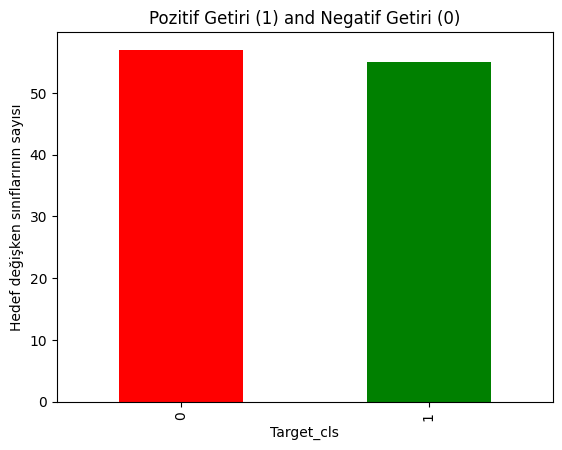

In [ ]:
counter = df["Target_cls"].value_counts()
counter.plot(kind="bar", color=["red", "green"])
plt.title("Pozitif Getiri (1) and Negatif Getiri (0)")
plt.ylabel("Hedef değişken sınıflarının sayısı")
plt.show();

In [ ]:
# Periyot boyunca tüm pozitif ve negatif getirilerin toplamı
print("Pozitig getiri toplamı: ₺", round(sum(i for i in df["Return"] if i>0),2))
print("Negatif getiri toplamı: ₺", round(sum(i for i in df["Return"] if i<0),2))

Pozitig getiri toplamı: ₺ 11.57
Negatif getiri toplamı: ₺ -10.46


In [ ]:
# Teknik analiz göstergeleri
import ta as ta
df["EMA10"] = ta.trend.ema_indicator(df["Price"], window=10, fillna=False)
df["EMA30"] = ta.trend.ema_indicator(df["Price"], window=26, fillna=False)
df["MACD"] = ta.trend.macd(df["Price"], window_fast=12, window_slow=26, fillna=False,)
df["MACDS"] = ta.trend.macd_signal(df["Price"], window_fast=12, window_slow=26, fillna=False)

In [ ]:
df["P_EMA10"] = np.where(df["Price"]>df["EMA10"], 1,0)
df["EMA10_EMA30"] = np.where(df["EMA10"]>df["EMA30"], 1,0)
df["MACD_MACDS"] = np.where(df["MACD"]>df["MACDS"], 1,0)

In [ ]:
print(df.isna().sum())
df.dropna(inplace=True)
print(df.isna().sum())

Open            0
High            0
Low             0
Close           0
Price           0
Volume          0
Return          1
Return_pct      1
Target_cls      0
EMA10           9
EMA30          25
MACD           25
MACDS          33
P_EMA10         0
EMA10_EMA30     0
MACD_MACDS      0
dtype: int64
Open           0
High           0
Low            0
Close          0
Price          0
Volume         0
Return         0
Return_pct     0
Target_cls     0
EMA10          0
EMA30          0
MACD           0
MACDS          0
P_EMA10        0
EMA10_EMA30    0
MACD_MACDS     0
dtype: int64


In [ ]:
df.head()

,Open,High,Low,Close,Price,Volume,Return,Return_pct,Target_cls,EMA10,EMA30,MACD,MACDS,P_EMA10,EMA10_EMA30,MACD_MACDS
Date,,,,,,,,,,,,,,,,
2024-04-22,8.675000,8.758333,8.300000,8.300000,8.300000,19140576,-0.375000,-0.043228,0,8.361761,8.203668,0.117160,0.032730,0,1,1
2024-04-24,8.333333,8.775000,8.245833,8.391666,8.391666,18646560,0.091666,0.011044,1,8.367199,8.217594,0.114133,0.049011,1,1,1
2024-04-25,8.425000,8.708333,8.400000,8.575000,8.575000,17623620,0.183333,0.021847,1,8.404981,8.244068,0.125085,0.064225,1,1,1
2024-04-26,8.608333,9.425000,8.583333,9.425000,9.425000,73361532,0.850000,0.099125,1,8.590439,8.331545,0.200046,0.091390,1,1,1
2024-04-29,10.366666,10.366666,9.583333,9.708333,9.708333,206238672,0.283333,0.030062,1,8.793692,8.433529,0.279099,0.128932,1,1,1


In [ ]:
# we will use only the following columns to predict target close.
predictor_list = ["P_EMA10",	"EMA10_EMA30",	"MACD_MACDS"]

X = df[predictor_list]
y = df["Target_cls"]

In [ ]:
# import time series cross validation

from tscv import GapWalkForward

cv = GapWalkForward(n_splits=15, gap_size=0, test_size=5)

model = DecisionTreeClassifier()

param_grid = {
    "max_depth":np.arange(3,10),
    "criterion":["gini", "entropy"],
    "min_samples_split": range(10,500,20)
}

grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=cv).fit(X,y)


In [ ]:
print("En iyi parametreler" + str(grid_dt.best_estimator_))
print("Izgara araması optimum parametreler" + str(grid_dt.best_params_))

En iyi parametrelerDecisionTreeClassifier(max_depth=3, min_samples_split=30)
Izgara araması optimum parametreler{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 30}


In [ ]:
clf = grid_dt.best_estimator_

from sklearn.model_selection import cross_val_score
dogruluk_oranları = cross_val_score(estimator=clf, X=X, y=y, cv=cv)
print(dogruluk_oranları)
print("Doğruluk oranları ortalaması: %0.3f ve standart sapması: %0.3f" % (dogruluk_oranları.mean(), dogruluk_oranları.std()))

[0.8 0.4 0.6 0.2 0.6 0.4 0.8 0.8 0.6 0.4 0.6 0.8 0.6 0.6 0.6]
Doğruluk oranları ortalaması: 0.587 ve standart sapması: 0.171


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


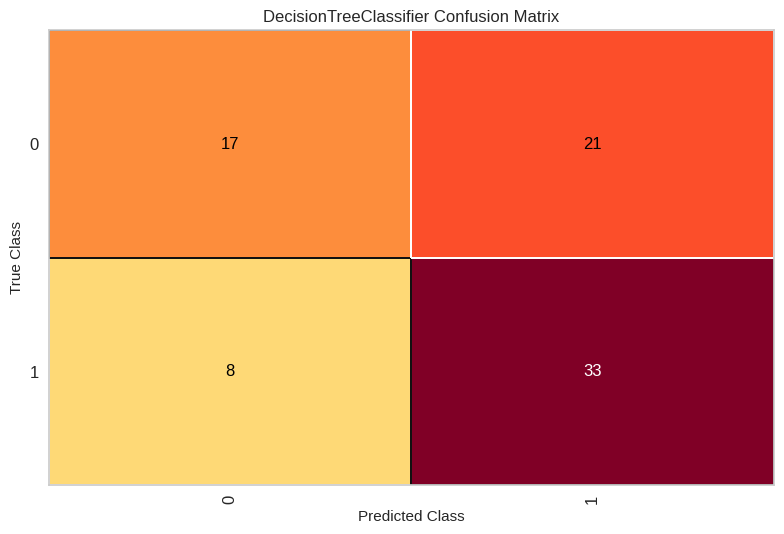

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

kategori = ["Sell", "Buy"]
cm=ConfusionMatrix(clf)
cm.fit(X,y)
cm.score(X,y)
cm.poof()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


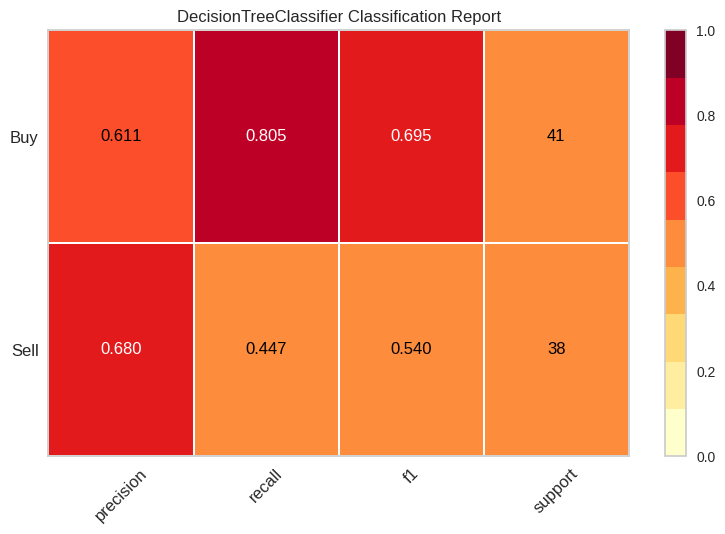

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [ ]:
from yellowbrick.classifier import ClassificationReport
cat = ["Sell", "Buy"]
cr = ClassificationReport(clf, classes=cat, support=True)
cr.fit(X,y)
cr.score(X,y)
cr.poof()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


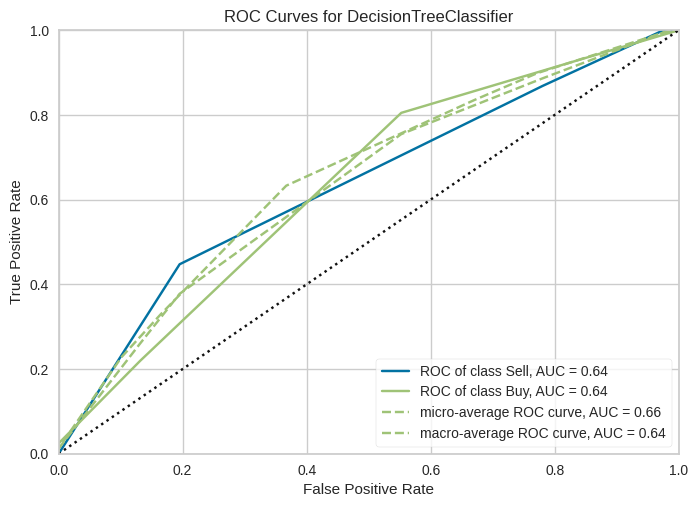

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
from yellowbrick import ROCAUC
ROC = ROCAUC(clf, macro=True, per_class=True, classes=cat)
ROC.fit(X,y)
ROC.score(X,y)
ROC.poof()

In [ ]:
df["Predicted_Signal"] = clf.predict(X)

In [ ]:
print("Doğruluk skoru: %0.2f" % accuracy_score(df["Target_cls"], df["Predicted_Signal"]))

Doğruluk skoru: 0.63


In [ ]:
df["Buy_DT"] = np.where((df["Predicted_Signal"]==1), 1, 0)
df["Sell_DT"] = np.where((df["Predicted_Signal"]==0), 1, 0)
df["Buy_DT_ind"] = np.where((df["Buy_DT"] > df["Buy_DT"].shift(1)), 1, 0)
df["Sell_DT_ind"] = np.where((df["Sell_DT"] > df["Sell_DT"].shift(1)), 1, 0)

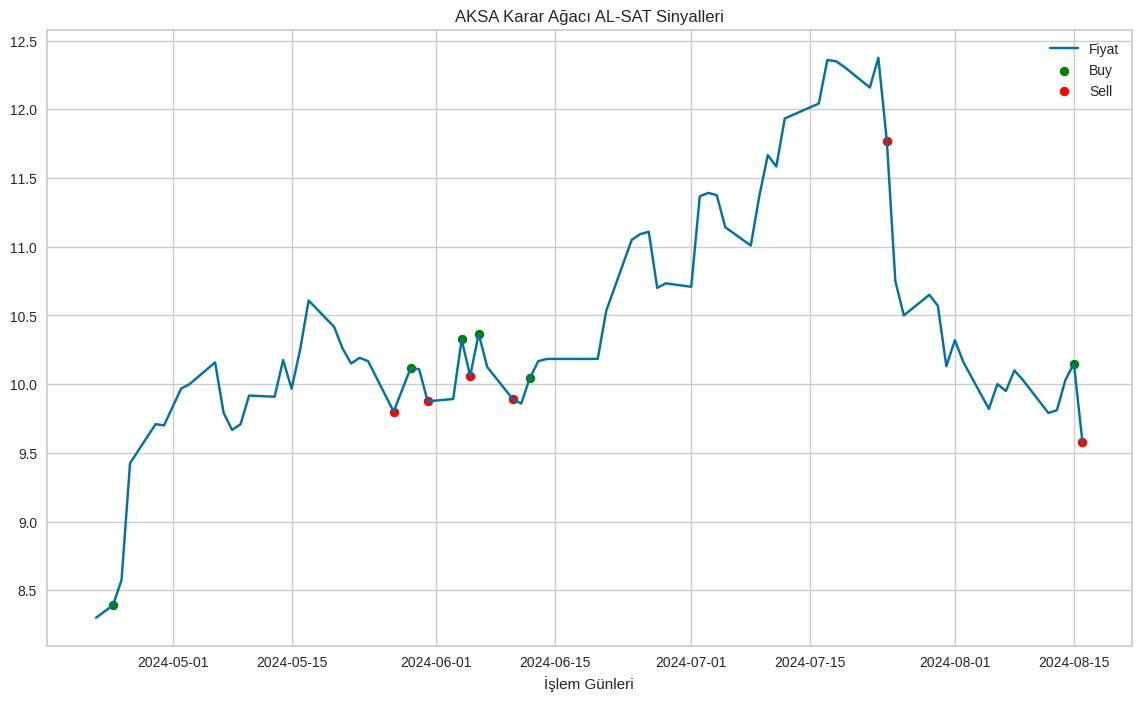

In [ ]:
df["Date"]=df.index

fig1 = plt.figure(figsize=(14,8))
plt.plot(df["Price"], label="Fiyat")
sns.scatterplot(x=df.loc[df["Buy_DT_ind"]==1, "Date"].values,
            y=df.loc[df["Buy_DT_ind"]==1, "Price"].values,
            label="Buy", color="green", s=55, markers="^")
sns.scatterplot(x=df.loc[df["Sell_DT_ind"]==1, "Date"].values,
            y=df.loc[df["Sell_DT_ind"]==1, "Price"].values,
            label="Sell", color="red", s=55, markers="v")
plt.xlabel("İşlem Günleri")
plt.legend(loc="best")
plt.title(f"{ticker} Karar Ağacı AL-SAT Sinyalleri")
plt.show();

In [ ]:
df["Value_DT"]=1000*(1+(np.where(df["Buy_DT"]==1,
                                 0.95*df["Return_pct"], 0)).cumsum())

In [ ]:
# Karar Ağacı için Back-Test Raporu

print(f"==== {ticker} Tanımlayıcı İstatistikler =====")
print("Periyot: ", len(df), "gün.")
print("En yüksek günlük kayıp: %", 100*round(df["Return_pct"].min(),2))
print("En yüksek günlük getiri: %", 100*round(df["Return_pct"].max(),2))
print("Toplam potansiyel getiri: %",
      100*round(sum(
          np.where((df["Return_pct"]>0), df["Return_pct"],0)),2))
print("Toplam potansiyel kayıp: %",
      100*round(sum(
          np.where((df["Return_pct"]<0), df["Return_pct"],0)),2))
print("Net getiri: %", 100*df["Return_pct"].sum().round(2))

print("==== Modelin Performansı ====")
print("Modelin yakaladığı getiri: ", 100*sum(np.where((df["Buy_DT"]==1), df["Return_pct"],0)))
print("Modelin koruduğu kayıp: ", 100*sum(np.where((df["Sell_DT"]==1), df["Return_pct"],0)))

print(f"Dönem başında ₺1000 olan yatırım dönem sonunda ₺ {round(df['Value_DT'][-1],2)} olmuştur")

==== AKSA Tanımlayıcı İstatistikler =====
Periyot:  79 gün.
En yüksek günlük kayıp: % -9.0
En yüksek günlük getiri: % 10.0
Toplam potansiyel getiri: % 87.0
Toplam potansiyel kayıp: % -74.0
Net getiri: % 13.0
==== Modelin Performansı ====
Modelin yakaladığı getiri:  52.3916067167152
Modelin koruduğu kayıp:  -39.47881212433424
Dönem başında ₺1000 olan yatırım dönem sonunda ₺ 1497.72 olmuştur


<ipython-input-39-89743f6c54ba>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Dönem başında ₺1000 olan yatırım dönem sonunda ₺ {round(df['Value_DT'][-1],2)} olmuştur")


In [ ]:
df

,Open,High,Low,Close,Price,Volume,Return,Return_pct,Target_cls,EMA10,...,P_EMA10,EMA10_EMA30,MACD_MACDS,Predicted_Signal,Buy_DT,Sell_DT,Buy_DT_ind,Sell_DT_ind,Date,Value_DT
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-22,8.675000,8.758333,8.300000,8.300000,8.300000,19140576,-0.375000,-0.043228,0,8.361761,...,0,1,1,0,0,1,0,0,2024-04-22,1000.000000
2024-04-24,8.333333,8.775000,8.245833,8.391666,8.391666,18646560,0.091666,0.011044,1,8.367199,...,1,1,1,1,1,0,1,0,2024-04-24,1010.491917
2024-04-25,8.425000,8.708333,8.400000,8.575000,8.575000,17623620,0.183333,0.021847,1,8.404981,...,1,1,1,1,1,0,0,0,2024-04-25,1031.246641
2024-04-26,8.608333,9.425000,8.583333,9.425000,9.425000,73361532,0.850000,0.099125,1,8.590439,...,1,1,1,1,1,0,0,0,2024-04-26,1125.415782
2024-04-29,10.366666,10.366666,9.583333,9.708333,9.708333,206238672,0.283333,0.030062,1,8.793692,...,1,1,1,1,1,0,0,0,2024-04-29,1153.974528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,10.050000,10.120000,9.760000,9.790000,9.790000,9601855,-0.240000,-0.023928,0,10.189155,...,0,0,0,0,0,1,0,0,2024-08-12,1486.354372
2024-08-13,9.780000,9.900000,9.650000,9.810000,9.810000,8255848,0.020000,0.002043,1,10.120218,...,0,0,0,0,0,1,0,0,2024-08-13,1486.354372
2024-08-14,9.830000,10.130000,9.830000,10.030000,10.030000,12303465,0.219999,0.022426,1,10.103815,...,0,0,0,0,0,1,0,0,2024-08-14,1486.354372
